# Semantic Segmentation Using DeepLab

In [1]:
# loading libraries
import numpy as np
import os
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime

import torch
from PIL import Image

import torchvision
import warnings
import torchvision.models as models
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from torch.optim import lr_scheduler 
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import DataLoader  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Data Loading

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
im_size = 112*2

x_transform =  transforms.Compose([#transforms.ToPILImage(),
                    transforms.Resize(im_size),
                    transforms.CenterCrop(im_size),
                    transforms.ToTensor(), 
                    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

y_transform =  transforms.Compose([#transforms.ToPILImage(),
                    transforms.Resize(im_size),
                    transforms.CenterCrop(im_size),
                    transforms.ToTensor()
                    ])

In [7]:
def info(image, label=None):
    print("image \n\t shape: ", image.shape, "\n\t type: ", image.type(), "\n\t min, max: ", float(image.min()),", ", float(image.max()), "\n\t unique: ", image.unique())
    if (label != None):
        print("label \n\t shape: ", label.shape, "\n\t type: ", label.type(), "\n\t min, max: ", float(label.min()),", ", float(label.max()), "\n\t unique: ", label.unique())

In [8]:
batch_size = 5

In [9]:
train_dataset = datasets.VOCSegmentation(root="../dataset/", year='2012', image_set='train', 
                                             download=False, transform=x_transform, target_transform=y_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = datasets.VOCSegmentation(root="../dataset/", year='2012', image_set='val', 
                                             download=False, transform=x_transform, target_transform=y_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)



# Model

In [10]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
# model = models.resnet101(pretrained=True)

In [11]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.8)

In [13]:
###################################### OVERFIT ######################################
###################################### OVERFIT ######################################

model.to(device)
begin_time = datetime.datetime.now()


model.train()
print("start training")
print("each epoch will have ", len(train_dataset)/batch_size, " steps/iterations")
for epoch in range(1):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device=device)
        targets = targets
        if (int(targets.max()) == int(1)):
            targets = targets*255
        targets = targets.to(device=device, dtype=torch.int64)
        targets = targets.squeeze(1)
        
        

        # forward
        out = model(data)['out']
        loss = criterion(out, targets)

        losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
        if(batch_idx % 50 == 0):            
            # scheduler.step()

            print(f"Cost at batch {batch_idx} is {sum(losses)/len(losses):.5f}")
           

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")
end_time = datetime.datetime.now()


print("duration: ", end_time-begin_time)

start training
each epoch will have  292.8  steps/iterations


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.19 GiB already allocated; 0 bytes free; 2.24 GiB reserved in total by PyTorch)

# Testing

In [11]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [12]:
def test(model, test_loader, batch_size=batch_size, overlay=False):
    model.eval()
    image, target = next(iter(test_loader))
    if (int(target.max()) == int(1)):
        target = target*255
    out = model(image)['out']


    for idx in range(batch_size):
        
        om = torch.argmax(out[idx].squeeze(), dim=0).detach().cpu().numpy()

        input_image  = image[idx].permute(1,2,0) * std[0] + torch.FloatTensor(mean)
        target_image = decode_segmap(target[idx].squeeze(0))
        output_image = decode_segmap(om)

        print(input_image.type())
        print(type(output_image))

        if (overlay):
            axes=[]
            fig=plt.figure(figsize=(6,6))
            plt.imshow(torch.FloatTensor(output_image) * 0.0033 + input_image * 0.65 )
            plt.show()
        else:
            axes=[]
            fig=plt.figure(figsize=(21,21))
            axes.append( fig.add_subplot(1, 3, 1) )
            plt.imshow( input_image  )
            axes[-1].set_title("input")

            axes.append( fig.add_subplot(1, 3, 2) )
            plt.imshow( target_image )
            axes[-1].set_title("target")

            axes.append( fig.add_subplot(1, 3, 3) )
            plt.imshow( output_image )
            axes[-1].set_title("output")

            plt.show()
        
    fig.tight_layout()
    model.train()   


torch.FloatTensor
<class 'numpy.ndarray'>


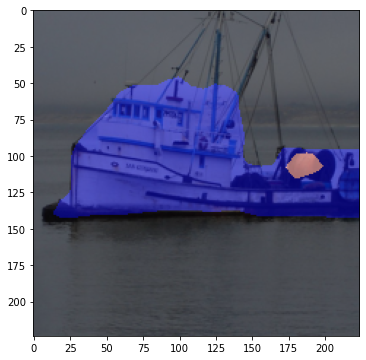

torch.FloatTensor
<class 'numpy.ndarray'>


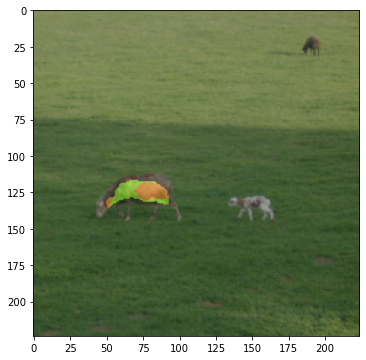

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.FloatTensor
<class 'numpy.ndarray'>


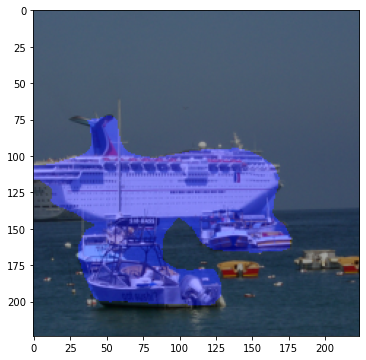

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.FloatTensor
<class 'numpy.ndarray'>


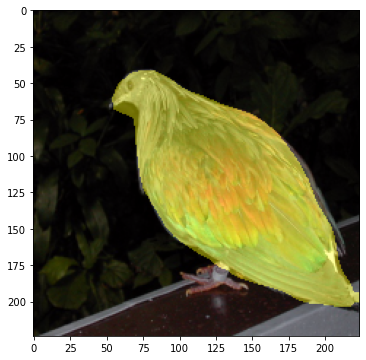

torch.FloatTensor
<class 'numpy.ndarray'>


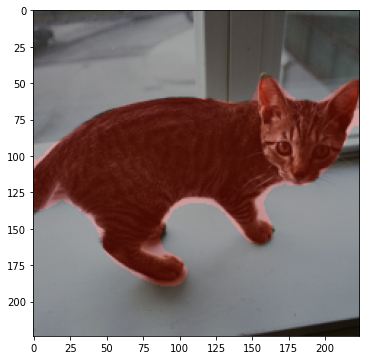

In [13]:
test(model.to('cpu'), test_loader, overlay=True )

In [13]:
# palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
# colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
# colors = (colors % 255).numpy().astype("uint8")

# # plot the semantic segmentation predictions of 21 classes in each color
# r = Image.fromarray(out[0].argmax(0).byte().cpu().numpy()).resize(im.size)
# r.putpalette(colors)

# import matplotlib.pyplot as plt
# plt.imshow(r)

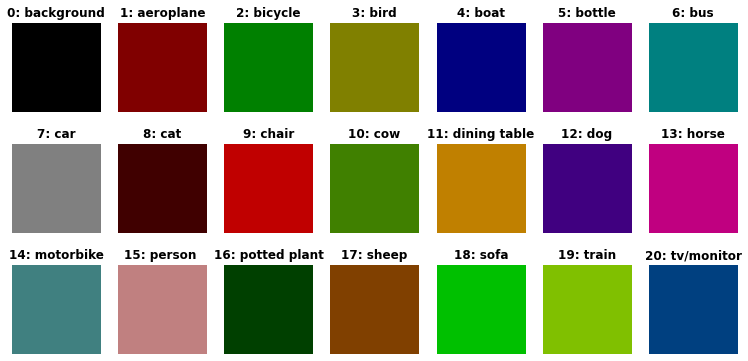

In [14]:
labels = ["0: background", "1: aeroplane", "2: bicycle", "3: bird", "4: boat", "5: bottle", "6: bus", "7: car", "8: cat", "9: chair", "10: cow", "11: dining table", "12: dog", "13: horse", "14: motorbike", "15: person ","16: potted plant", "17: sheep", "18: sofa", "19: train", "20: tv/monitor"]

width = 2
height = 2
rows = 6
cols = 7

axes=[]
fig=plt.figure(figsize=(13,13))

for a in range(21):
    # b = np.random.randint(7, size=(height,width))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=(str(labels[a]))
    axes[-1].set_title(subplot_title,fontweight="bold")
    z = np.array([[a, a],[a, a]])
    plt.imshow(decode_segmap(z))
    plt.axis('off')  
# fig.tight_layout()    
plt.show()


In [14]:
torch.save(model.state_dict(), 'model1.ckpt')

In [83]:
from PIL import Image
PATH = r"C:\Users\20182475\OneDrive - TU Eindhoven\TUe documents\BAU3\Honors - Smart Mobility\jupyter notebooks\semantic segmentation\test_segmentation"
bird = Image.open(PATH + "/bird.jpeg")
chair = Image.open(PATH + "/chair.jpeg")
person = Image.open(PATH + "/person.jpeg")
bottle = Image.open(PATH + "/bottle.jpeg")
plant = Image.open(PATH + "/plant.jpeg")

In [84]:
bird = x_transform(bird)
chair = x_transform(chair)
person = x_transform(person)
bottle = x_transform(bottle)
plant = x_transform(plant)

In [85]:
test_list = [bird, chair, person, bottle, plant]

In [90]:
def test_(model, test_list):
    model.eval()
    
   
    for idx in range(len(test_list)):

        out = model(test_list[idx].unsqueeze(0))['out']
        print(out.shape)
        om = torch.argmax(out.squeeze(0), dim=0).detach().cpu().numpy()
        print("om ", om.shape)
        input_image  = test_list[idx].permute(1,2,0) * std[0] + torch.FloatTensor(mean)
        output_image = decode_segmap(om)

        print("output ", output_image.shape)


        axes=[]
        fig=plt.figure(figsize=(15,15))
        plt.imshow(torch.FloatTensor(output_image) * 0.0033 + input_image * 0.65 )
        plt.show()
       
    fig.tight_layout()
    model.train()   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([1, 21, 224, 224])
om  (224, 224)
output  (224, 224, 3)


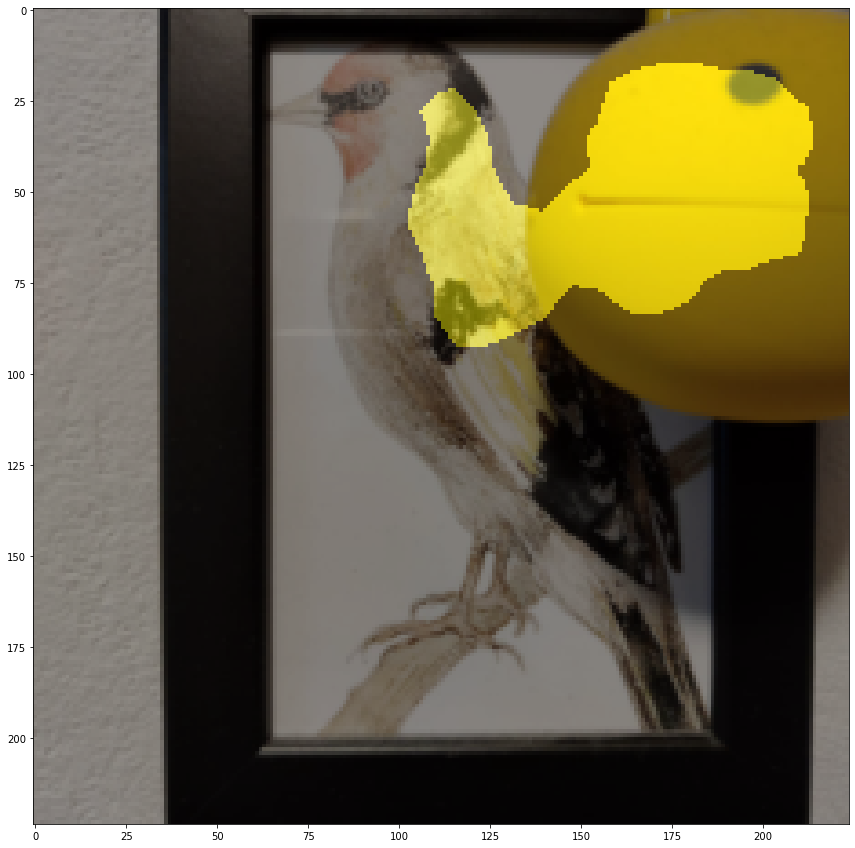

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([1, 21, 224, 224])
om  (224, 224)
output  (224, 224, 3)


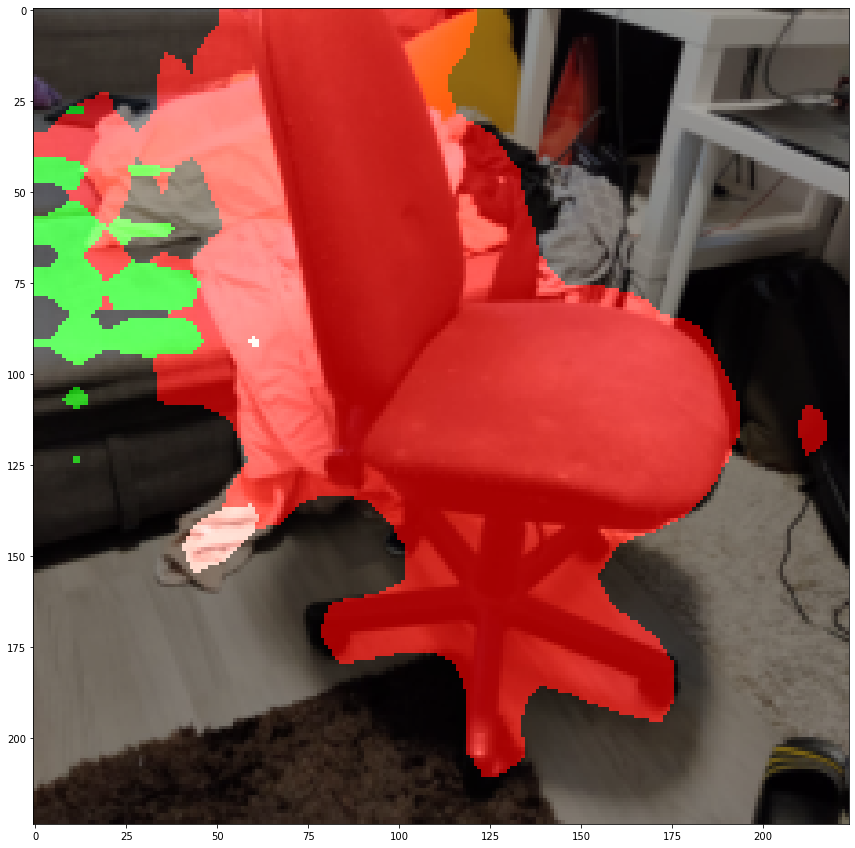

torch.Size([1, 21, 224, 224])
om  (224, 224)
output  (224, 224, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


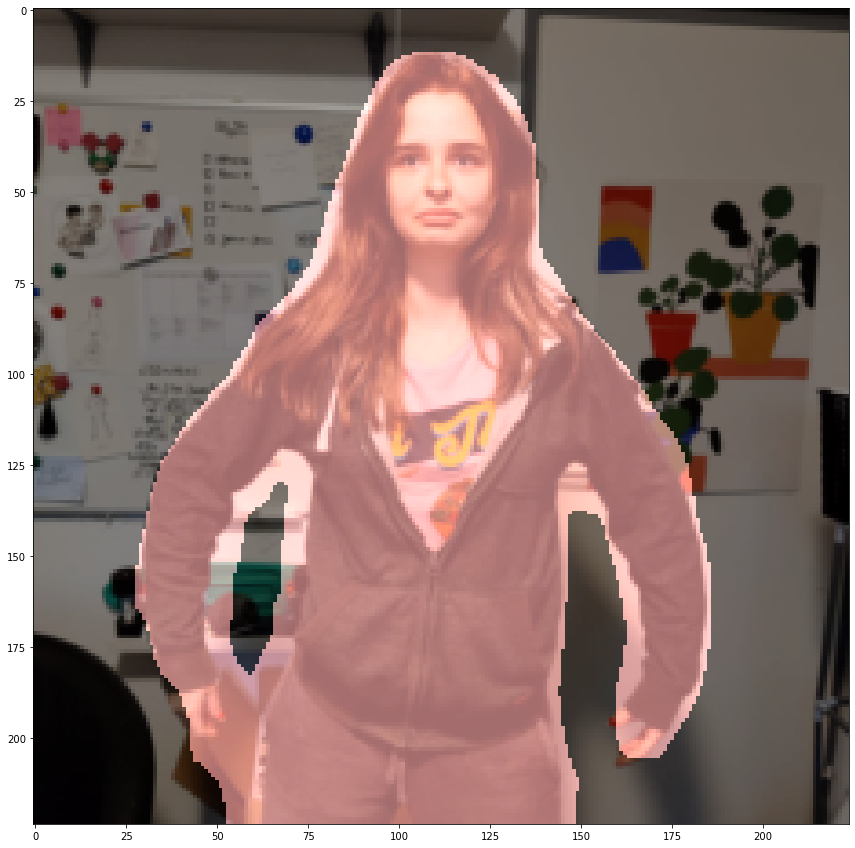

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([1, 21, 224, 224])
om  (224, 224)
output  (224, 224, 3)


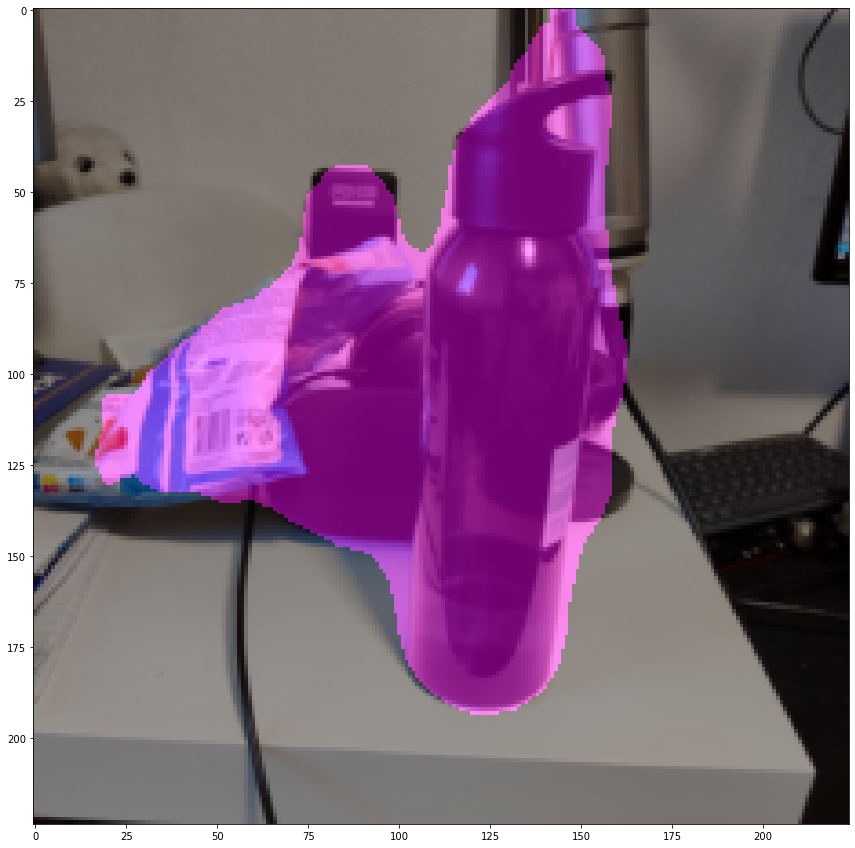

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([1, 21, 224, 224])
om  (224, 224)
output  (224, 224, 3)


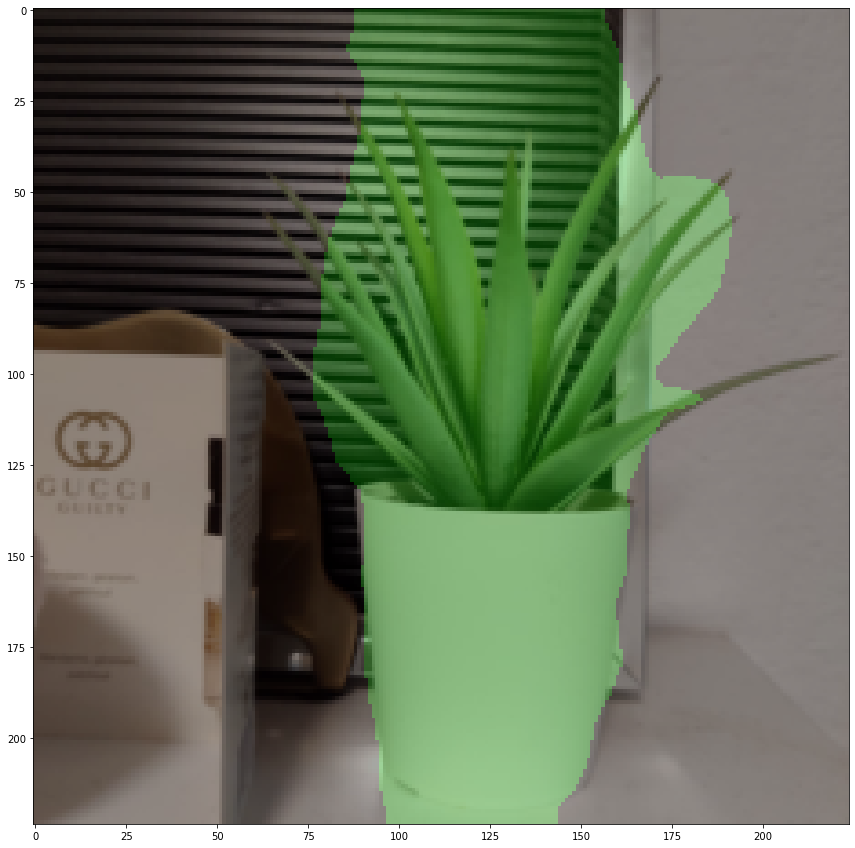

In [91]:
test_(model, test_list)

In [64]:
 test_list[0].permute(1,2,0).shape

torch.Size([224, 224, 3])